# Statistical Analysis of the seeds dataset

This notebook contains the code and results of the anaysis done on the seeds dataset. Bootstrapping is a wonderful approach to test if the sample statistics are representative of the true popoulation statistics. A comparison of Pearson correlation coefficients determines which features are highly correlated, and in essence can then be left out of the final model to reduce redundancy and increase performance.  

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as st
import statsmodels as sm
%matplotlib inline


In [2]:
#Load the data into a data frame and separate into X and y.
seeds = pd.read_csv('seeds.csv')

In [13]:
#Separate the classes for sampling:
seeds1 = seeds[seeds["class"]==1]
seeds2 = seeds[seeds["class"]==2]
seeds3 = seeds[seeds["class"]==3]
seeds2.tail()

,area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length,class
135,15.38,14.66,0.8990,5.477,3.465,3.600,5.439,2.0
136,17.36,15.76,0.8785,6.145,3.574,3.526,5.971,2.0
137,15.57,15.15,0.8527,5.920,3.231,2.640,5.879,2.0
138,15.60,15.11,0.8580,5.832,3.286,2.725,5.752,2.0
139,16.23,15.18,0.8850,5.872,3.472,3.769,5.922,2.0


## Bootstrapping

In this section we randomly sample the data for each class, creating 10,000 random samples of the training data, all of equal size. We compare the results with histograms and find the confidence interval and p-value for each. This value will let us know how representative of the world's population is the samle's data.

In [14]:
def mean_sampler(df, draws=1, itrs=1):
    samples = pd.DataFrame({'means':[df.sample(n=draws ,replace=True, random_state=np.random.randint(0,1000), \
                                               axis=0).mean() for i in range(itrs) ] } )
    return(samples)

In [16]:
mean_samples1 = mean_sampler(seeds1.area, draws=len(seeds1), itrs=10000)

In [21]:
#Visualize the distribution compared to the original:
mean_samples1.tail()

,means
9995,14.514286
9996,14.327571
9997,14.331143
9998,14.452714
9999,14.238429


In [34]:
#Now look at the statistics of the variables:
area_mean1 = seeds1.area.mean()
areamean_bs1 = float(samples1.mean().values)
print("Bootstrap mean(cm):",areamean_bs1 ,"  Original mean(cm):",area_mean1)

Bootstrap mean(cm): 14.333227757142904   Original mean(cm): 14.33442857142857


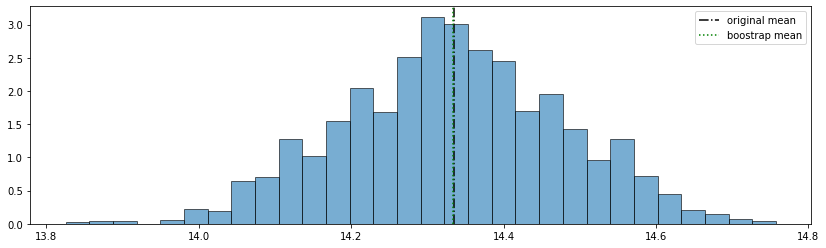

In [45]:
_=plt.figure(figsize=(14,4))
_=plt.hist(samples1.means, bins=30, edgecolor='k', alpha=.6, density=True)
_=plt.axvline(area_mean1, linestyle='-.', color='k')
_=plt.axvline(areamean_bs1, linestyle=':', color='g')
_=plt.legend(['original mean','boostrap mean'])

In [46]:
lower = round(samples1.means.quantile(.025),2)
upper = round(samples1.means.quantile(.975),2)
print('95% confidence interval between', lower, ' and ', upper, 'cm.')

95% confidence interval between 14.05  and  14.61 cm.


In [35]:
seeds

,area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1.0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1.0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1.0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1.0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1.0
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3.0
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3.0
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3.0
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3.0


In [44]:
print(seeds1.asymmetry_coefficient.std(),\
      seeds2.asymmetry_coefficient.std(),\
      seeds3.asymmetry_coefficient.std())

1.1739012862446276 1.1818682900697792 1.3364649282146637


In [82]:
obs_diff = seeds3.asymmetry_coefficient.std() - seeds1.asymmetry_coefficient.std()
obs_diff

0.16256364197003603

In [83]:
seeds1_shifted = pd.DataFrame(seeds1.asymmetry_coefficient - seeds1.asymmetry_coefficient.mean() + obs_diff)
#seeds2_shifted = pd.DataFrame(seeds2.asymmetry_coefficient - seeds2.asymmetry_coefficient.mean() + obs_diff)
seeds3_shifted = pd.DataFrame(seeds3.asymmetry_coefficient - seeds3.asymmetry_coefficient.mean() + obs_diff)


In [84]:
std_sample = pd.DataFrame({'std_diff':[round(seeds1_shifted.asymmetry_coefficient.sample(len(seeds1),replace=True).std()-\
                                             seeds2_shifted.asymmetry_coefficient.sample(len(seeds2),replace=True).std(),2)\
                                       for i in range(20000)]})

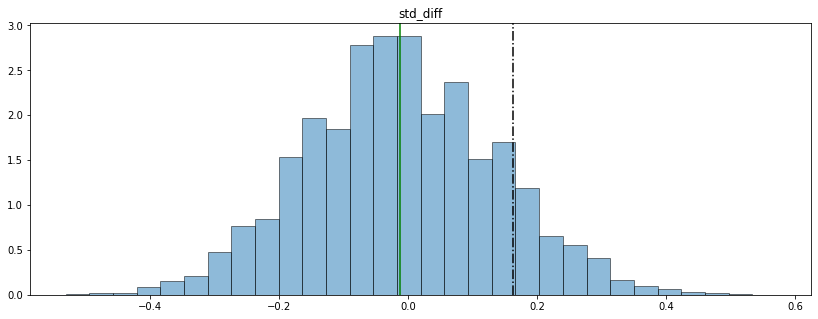

In [92]:
_=std_sample.hist(bins=30, edgecolor='k', figsize=(14,5), grid=False, alpha=.5, density=True)
_=plt.axvline(obs_diff, color='k', linestyle="-.")
_=plt.axvline(std_sample.std_diff.mean(), color='green')

In [89]:
std_sample.quantile([.025, .975])

,std_diff
0.025,-0.30
0.975,0.29


In [93]:
st.percentileofscore(std_sample, score=obs_diff)

88.285

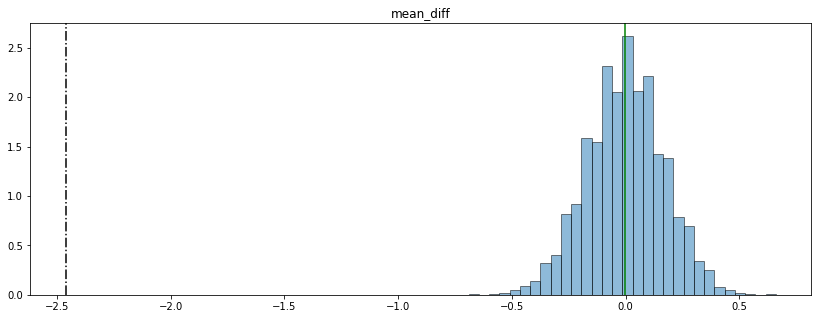

In [95]:
obs_diff = seeds3.area.mean() - seeds1.area.mean()
seeds1_shifted = pd.DataFrame(seeds1.area - seeds1.area.mean() + obs_diff)
#seeds2_shifted = pd.DataFrame(seeds2.asymmetry_coefficient - seeds2.asymmetry_coefficient.mean() + obs_diff)
seeds3_shifted = pd.DataFrame(seeds3.area - seeds3.area.mean() + obs_diff)
mean_diff = pd.DataFrame({'mean_diff':[round(seeds1_shifted.area.sample(len(seeds1),replace=True).mean()-\
                                             seeds3_shifted.area.sample(len(seeds3),replace=True).mean(),2)\
                                       for i in range(20000)]})
_=mean_diff.hist(bins=30, edgecolor='k', figsize=(14,5), grid=False, alpha=.5, density=True)
_=plt.axvline(obs_diff, color='k', linestyle="-.")
_=plt.axvline(mean_diff.mean_diff.mean(), color='green')

In [96]:
st.percentileofscore(mean_diff, score=obs_diff)

0.0

In [97]:
mean_diff.quantile([.025,.975])

,mean_diff
0.025,-0.34
0.975,0.32


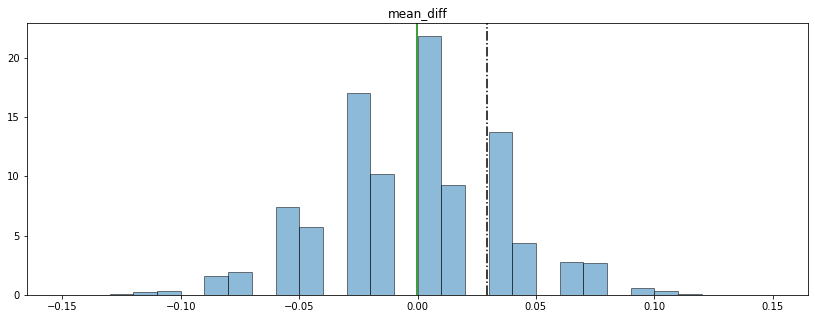

In [102]:
obs_diff = seeds3.groove_length.mean() - seeds1.groove_length.mean()
seeds1_shifted = pd.DataFrame(seeds1.groove_length - seeds1.groove_length.mean() + obs_diff)
seeds2_shifted = pd.DataFrame(seeds2.groove_length - seeds2.groove_length.mean() + obs_diff)
seeds3_shifted = pd.DataFrame(seeds3.groove_length - seeds3.groove_length.mean() + obs_diff)
mean_diff = pd.DataFrame({'mean_diff':[round(seeds3_shifted.groove_length.sample(len(seeds3),replace=True).mean()-\
                                             seeds1_shifted.groove_length.sample(len(seeds2),replace=True).mean(),2)\
                                       for i in range(20000)]})
_=mean_diff.hist(bins=30, edgecolor='k', figsize=(14,5), grid=False, alpha=.5, density=True)
_=plt.axvline(obs_diff, color='k', linestyle="-.")
_=plt.axvline(mean_diff.mean_diff.mean(), color='green')

## Pearson Correlation Coefficient

In this section we look for correlation between the features by calculating the Pearson Correlation Coefficient for each feature. 

In [201]:
def pearsonr(data):
    values = {}
    rlst =[]
    plst = []
    cols = []
    for i in range(len(data.columns)-1):
        for j in range(len(data.columns)-1):
            if j != i:
                r,p = st.pearsonr(data[data.columns[i]],data[data.columns[j]])
                cols.append((data.columns[i], data.columns[j]))
                rlst.append(r)
                plst.append(p)
                values = pd.DataFrame({'features':cols, 'r':rlst, 'p':plst})
                values.index=values['features']
                values.drop(labels='features', axis=1, inplace=True)
    return(values)
    

In [206]:
test = pearsonr(seeds2)
test.drop('p', axis=1, inplace=True)
test.head()

,r
features,
"(area, perimeter)",0.975806
"(area, compactness)",0.272633
"(area, length)",0.826427
"(area, width)",0.880493
"(area, asymmetry_coefficient)",-0.039503


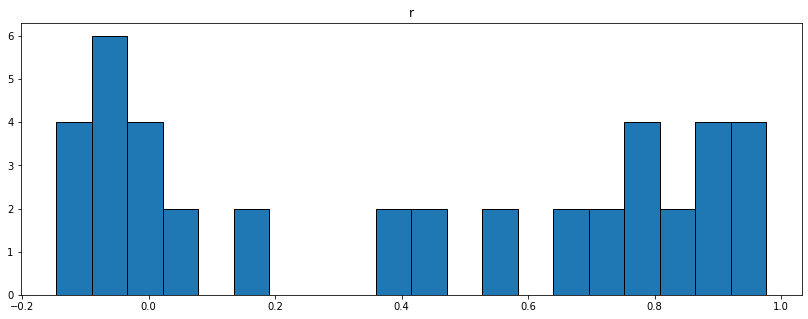

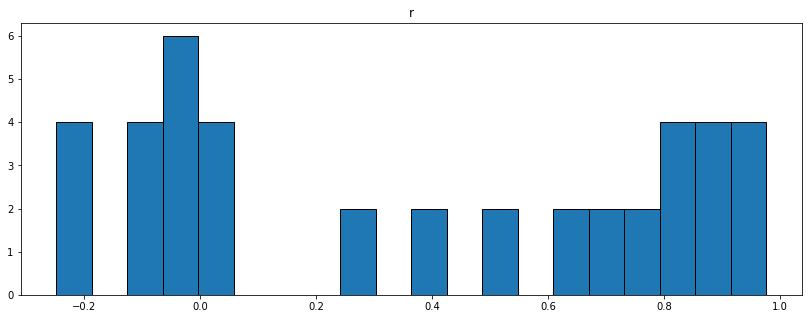

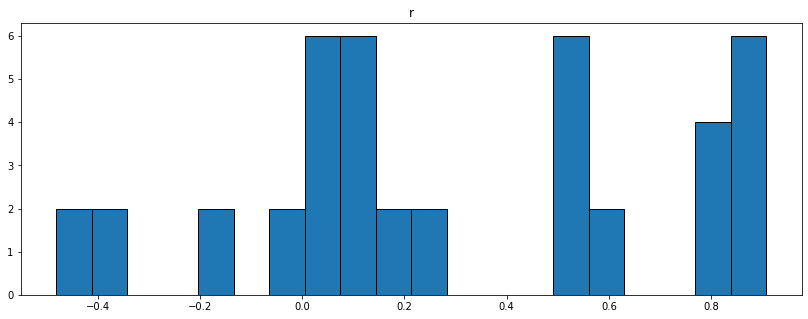

In [220]:
pearsonDF1 = pearsonr(seeds1)
pearsonDF2 = pearsonr(seeds2)
pearsonDF3 = pearsonr(seeds3)
_=pearsonDF1.drop('p', axis=1).hist(bins=20, figsize=(14,5), grid=False, edgecolor='k')
_=pearsonDF2.drop('p', axis=1).hist(bins=20, figsize=(14,5), grid=False, edgecolor='k')
_=pearsonDF3.drop('p', axis=1).hist(bins=20, figsize=(14,5), grid=False, edgecolor='k')

In [221]:
pearsonDF1.drop('p', axis=1, inplace=True)
pearsonDF2.drop('p', axis=1, inplace=True)
pearsonDF3.drop('p', axis=1, inplace=True)


In [285]:
merged = pearsonDF1.merge(pearsonDF2, on=pearsonDF1.index)
merged.index=merged['key_0']
merged.drop('key_0', axis=1, inplace=True)
merged = merged.merge(pearsonDF3, on=merged.index)
merged.index=merged['key_0']
merged.drop('key_0', axis=1, inplace=True)
merged.drop_duplicates(inplace=True)
merged.columns = ['Kama','Rosa','Canadia']
merged.index.name = 'features'
merged.head()

,Kama,Rosa,Canadia
features,,,
"(area, perimeter)",0.976437,0.975806,0.907601
"(area, compactness)",0.371037,0.272633,0.546760
"(area, length)",0.834778,0.826427,0.516603
"(area, width)",0.900066,0.880493,0.863824
"(area, asymmetry_coefficient)",-0.050482,-0.039503,0.039612


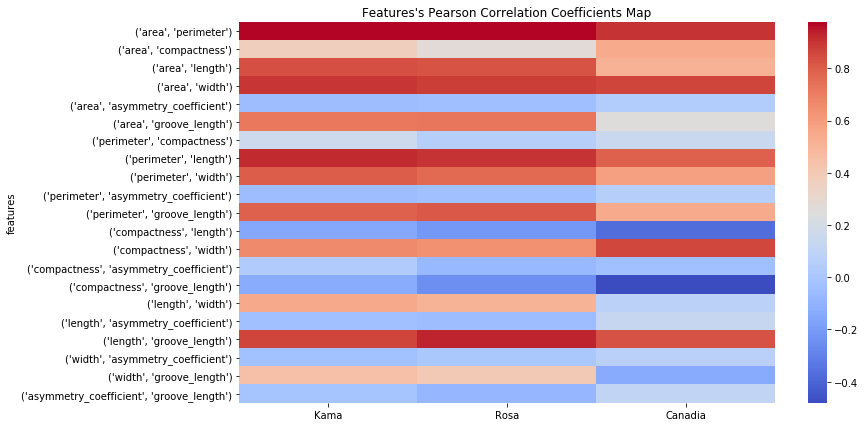

In [286]:
_=plt.figure(figsize=(12,7))
_=sns.heatmap(merged, cmap='coolwarm')
_=plt.title('Features\'s Pearson Correlation Coefficients Map')